Object Detection by using Keras
-----------------

The SSD (Single Shot Detector) is the best candidate compares with Fast R-CNN or Yolo compromising the accuracy, speed, and detect the small objects. 

In Tensorflow, it has the default object detection library using the SSD and it works great. However, the Tensorflow does not expose the training process, and there is no way to manage the model hyper parameters, so we decided to use the Keras and the open source SSD implementation for Keras https://github.com/pierluigiferrari/ssd_keras, which allows us can customize the model hyper parameters, and explore the API easier.


We use two datasets PASCAL VOC 2007 and PASCAL VOC 2012. This notebook is written to run on Google Colab which provides us the great GPU processing that we can not have in our Macbook! 


References
--------------------

1. [Github - A Keras port of Single Shot MultiBox Detector](https://github.com/pierluigiferrari/ssd_keras)

2. [Transfer Learning using Mobilenet and Keras](https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299)

3. [How to Use The Pre-Trained VGG Model to Classify Objects in Photographs](https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/)

4. [Transfer learning & The art of using Pre-trained Models in Deep Learning](https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model/)

5. [Review: SSD — Single Shot Detector (Object Detection)](https://towardsdatascience.com/review-ssd-single-shot-detector-object-detection-851a94607d11)

## Clone the Keras SSD library to the Colab workspace

In [0]:
%cd /content
%mkdir ssd-keras
!git clone -l -s git://github.com/pierluigiferrari/ssd_keras.git ssd-keras

/content
Cloning into 'ssd-keras'...
remote: Enumerating objects: 1608, done.
remote: Total 1608 (delta 0), reused 0 (delta 0), pack-reused 1608
Receiving objects: 100% (1608/1608), 19.71 MiB | 6.42 MiB/s, done.
Resolving deltas: 100% (1056/1056), done.


## Download the datasets for training

In [0]:
%cd /content/ssd-keras/
!mkdir data
%cd data

!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar  


!tar -xf VOCtrainval_11-May-2012.tar
!tar -xf VOCtrainval_06-Nov-2007.tar
!tar -xf VOCtest_06-Nov-2007.tar 

!wget https://raw.githubusercontent.com/circulosmeos/gdown.pl/master/gdown.pl
!chmod a+x gdown.pl
!./gdown.pl https://drive.google.com/file/d/1sBmajn6vOE7qJ8GnxUJt4fGPuffVUZox/view VGG_ILSVRC_16_layers_fc_reduced.h5

Cannot open cookies file ‘gdown.cookie.temp’: No such file or directory
--2019-06-20 12:43:55--  https://docs.google.com/uc?id=1sBmajn6vOE7qJ8GnxUJt4fGPuffVUZox&export=download
Resolving docs.google.com (docs.google.com)... 108.177.125.139, 108.177.125.100, 108.177.125.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.125.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-1c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tle28p5neq1cfq1hbbnd8fuaiane653a/1561032000000/01021765827329596762/*/1sBmajn6vOE7qJ8GnxUJt4fGPuffVUZox?e=download [following]
--2019-06-20 12:43:58--  https://doc-0s-1c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tle28p5neq1cfq1hbbnd8fuaiane653a/1561032000000/01021765827329596762/*/1sBmajn6vOE7qJ8GnxUJt4fGPuffVUZox?e=download
Resolving doc-0s-1c-docs.googleusercontent.com (doc-0s-1c-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:

## Images EDA (Dataset PASCAL VOC 2012, 2007)

We analyze the data of the training images. The size of the images which impacts to the training and prediction values. We have the following conventions:

* If the ratio between width and high in [0.8, 1.2] then we consider the image shape is square

* If the ratio between width and high is greater than 1.2, then image shape is lanscape

* Otherwise, image shape is portrait

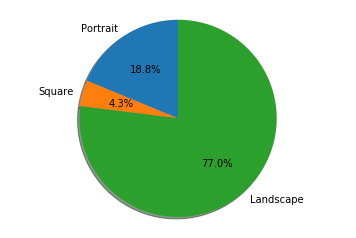

In [0]:
from pathlib import Path
from PIL import Image

def sizesStats(path):
  # List all subdirectory using pathlib
  basepath = Path(path)
  ts = 0
  tp = 0
  tl = 0
  for entry in basepath.iterdir():
      image  = Image.open(entry)
      width, height = image.size
      ratio = width / height
      if ratio > 0.8 and ratio < 1.2:
          ts +=1
      elif ratio >= 1.2:
          tl += 1
      else:
          tp +=1
  return tp, ts, tl    
    
p2012, s2012, l2012 = sizesStats("/content/ssd-keras/data/VOCdevkit/VOC2012/JPEGImages") 
p2007, s2007, l2007 = sizesStats("/content/ssd-keras/data/VOCdevkit/VOC2007/JPEGImages") 

p, s, l = p2012 + p2007, s2012 + s2007, l2012 + l2007

import matplotlib.pyplot as plt

names = ['Portrait', 'Square', 'Landscape']
values = [p, s, l]

fig1, ax1 = plt.subplots()

ax1.pie(values, labels=names, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

The lanscape images has more quantity than portrait and square types

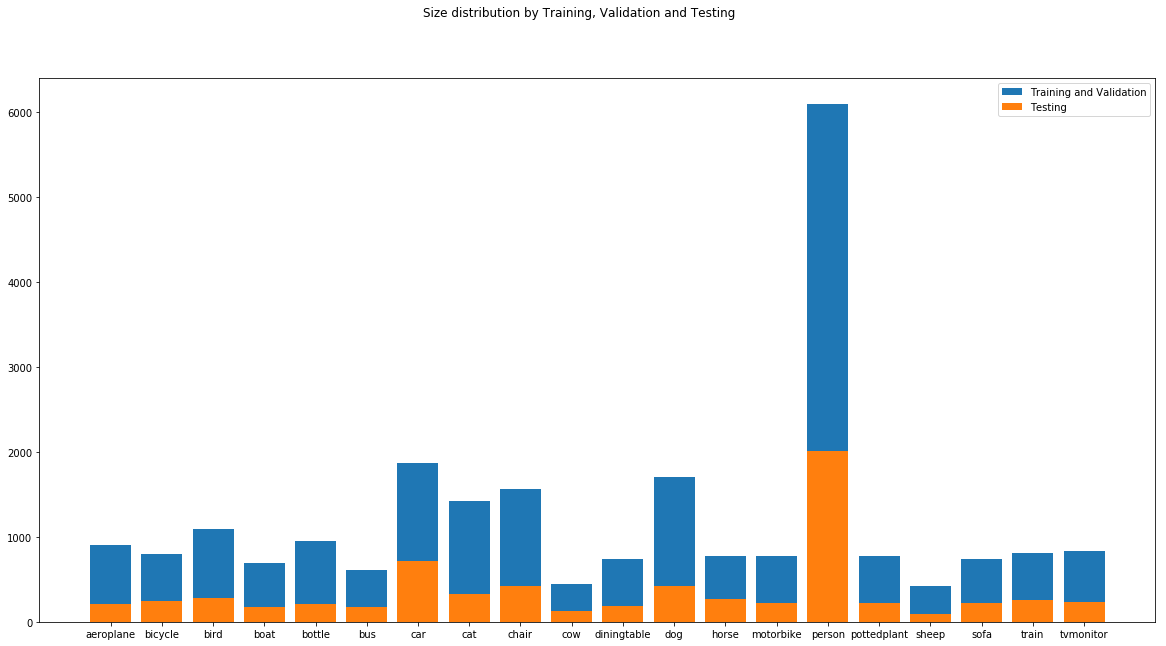

In [0]:
def countLineOfFile(filename):
    f = open(filename, "r")
    count = 0
    for line in f:
        if line.endswith(" 1\n"):
            count = count + 1
    return count        


classes_trainval = {'aeroplane': 0, 'bicycle': 0, 'bird': 0, 'boat': 0,
               'bottle': 0, 'bus': 0, 'car': 0, 'cat': 0,
               'chair': 0, 'cow': 0, 'diningtable': 0, 'dog': 0,
               'horse': 0, 'motorbike': 0, 'person': 0, 'pottedplant': 0,
               'sheep': 0, 'sofa': 0, 'train': 0, 'tvmonitor': 0}

classes_test = {'aeroplane': 0, 'bicycle': 0, 'bird': 0, 'boat': 0,
               'bottle': 0, 'bus': 0, 'car': 0, 'cat': 0,
               'chair': 0, 'cow': 0, 'diningtable': 0, 'dog': 0,
               'horse': 0, 'motorbike': 0, 'person': 0, 'pottedplant': 0,
               'sheep': 0, 'sofa': 0, 'train': 0, 'tvmonitor': 0}

path2012 = "/content/ssd-keras/data/VOCdevkit/VOC2012/ImageSets/Main/"
path2007 = "/content/ssd-keras/data/VOCdevkit/VOC2007/ImageSets/Main/"

for classKey in classes_trainval.keys():
    filePath = path2012 + classKey + "_trainval.txt"
    classes_trainval[classKey] = countLineOfFile(filePath)
    filePath = path2007 + classKey + "_trainval.txt"
    classes_trainval[classKey] = classes_trainval[classKey] + countLineOfFile(filePath)
    
    filePath = path2007 + classKey + "_test.txt"
    classes_test[classKey] = countLineOfFile(filePath)

plt.figure(figsize=(20,10))
p1 = plt.bar(classes_trainval.keys(), classes_trainval.values())
p2 = plt.bar(classes_test.keys(), classes_test.values())
plt.suptitle('Size distribution by Training, Validation and Testing')
plt.legend((p1[0], p2[0]), ('Training and Validation', 'Testing'))
plt.show()

We need more pictures to help the machine detect the people than other classes

## Training 

* Disclaimer: All sources are credited to this repo https://github.com/pierluigiferrari/ssd_keras

In [0]:
import sys
sys.path.append("/content/ssd-keras")

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

Using TensorFlow backend.


In [0]:
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 20 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

In [0]:
import warnings
warnings.filterwarnings('ignore')
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)

# 2: Load some weights into the model.

weights_path = '/content/ssd-keras/data/VGG_ILSVRC_16_layers_fc_reduced.h5'

model.load_weights(weights_path, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)


print(model.summary())

W0620 14:22:31.448597 140512939751296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0620 14:22:31.453116 140512939751296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0620 14:22:31.495954 140512939751296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0620 14:22:31.497724 140512939751296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W062

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 300, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_channel_swap (Lambda)     (None, 300, 300, 3)  0           input_mean_normalization[0][0]   
__________________________________________________________________________________________________
conv1_1 (C

In [0]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets. This can take a while.

# TODO: Set the paths to the datasets here.

# The directories that contain the images.
VOC_2007_images_dir      = '/content/ssd-keras/data/VOCdevkit/VOC2007/JPEGImages/'
VOC_2012_images_dir      = '/content/ssd-keras/data/VOCdevkit/VOC2012/JPEGImages/'

# The directories that contain the annotations.
VOC_2007_annotations_dir      = '/content/ssd-keras/data/VOCdevkit/VOC2007/Annotations/'
VOC_2012_annotations_dir      = '/content/ssd-keras/data/VOCdevkit/VOC2012/Annotations/'

# The paths to the image sets.
VOC_2007_train_image_set_filename    = '/content/ssd-keras/data/VOCdevkit/VOC2007/ImageSets/Main/train.txt'
VOC_2012_train_image_set_filename    = '/content/ssd-keras/data/VOCdevkit/VOC2012/ImageSets/Main/train.txt'
VOC_2007_val_image_set_filename      = '/content/ssd-keras/data/VOCdevkit/VOC2007/ImageSets/Main/val.txt'
VOC_2012_val_image_set_filename      = '/content/ssd-keras/data/VOCdevkit/VOC2012/ImageSets/Main/val.txt'
VOC_2007_trainval_image_set_filename = '/content/ssd-keras/data/VOCdevkit/VOC2007/ImageSets/Main/trainval.txt'
VOC_2012_trainval_image_set_filename = '/content/ssd-keras/data/VOCdevkit/VOC2012/ImageSets/Main/trainval.txt'
VOC_2007_test_image_set_filename     = '/content/ssd-keras/data/VOCdevkit/VOC2007/ImageSets/Main/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

train_dataset.parse_xml(images_dirs=[VOC_2007_images_dir,
                                     VOC_2012_images_dir],
                        image_set_filenames=[VOC_2007_trainval_image_set_filename,
                                             VOC_2012_trainval_image_set_filename],
                        annotations_dirs=[VOC_2007_annotations_dir,
                                          VOC_2012_annotations_dir],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                      image_set_filenames=[VOC_2007_test_image_set_filename],
                      annotations_dirs=[VOC_2007_annotations_dir],
                      classes=classes,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=True,
                      ret=False)

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.

train_dataset.create_hdf5_dataset(file_path='dataset_pascal_voc_07+12_trainval.h5',
                                  resize=False,
                                  variable_image_size=True,
                                  verbose=True)

val_dataset.create_hdf5_dataset(file_path='dataset_pascal_voc_07_test.h5',
                                resize=False,
                                variable_image_size=True,
                                verbose=True)

Creating HDF5 dataset: 100%|██████████| 4952/4952 [00:54<00:00, 91.15it/s] 


In [0]:
# 3: Set the batch size.

batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=False,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	 16551
Number of images in the validation dataset:	  4952


In [0]:
# Define a learning rate schedule.

def lr_schedule(epoch):
    if epoch < 80:
        return 0.0001
    elif epoch < 100:
        return 0.0001
    else:
        return 0.00001

In [0]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath='ssd300_pascal_07+12_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
#model_checkpoint.best = 

csv_logger = CSVLogger(filename='ssd300_pascal_07+12_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]

In [0]:
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 4
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 1/4

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
 588/1000 [================>.............] - ETA: 14:56 - loss: 9.9614

dict_keys(['val_loss', 'loss', 'lr'])


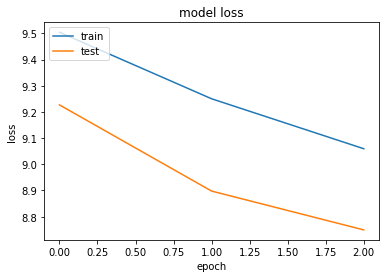

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()